In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("white")

In [105]:
# archetype = "Southern"
archetype = "Sahel"

In [113]:
def get_agg_df_w_baseline(archetype):
    def _add_drug_length(df):
        df["drug_length"] = -1
        df.loc[df["drug_type"]=="DP", "drug_length"] = 28
        df.loc[np.logical_or(df["drug_type"]=="ASAQ", df["drug_type"]=="SPAQ"), "drug_length"] = 14
        
    scenario_df = pd.read_csv("../scenario_master_list.csv")
    scenario_df = scenario_df[scenario_df["archetype"]==archetype].reset_index(drop=True)

    if archetype == "Sahel":
        df = pd.read_csv("endpoints_302c6451-7496-eb11-a2ce-c4346bcb1550.csv")
    elif archetype == "Southern":
        df = pd.read_csv("endpoints_e8935259-0b93-eb11-a2ce-c4346bcb1550.csv") 

    # df cleaning
    df["out_of_school_rate"] = np.round(df["out_of_school_rate"],2)
    _add_drug_length(df)
    
    df_baseline = df[df["scenario_number"]==30].groupby("burnin_approx_pfpr2_10").agg("mean").reset_index()
#     df_allout = df[df["scenario_number"]==27].groupby("burnin_approx_pfpr2_10").agg("mean").reset_index()

    df_agg = df.groupby(["burnin_approx_pfpr2_10", "scenario_number"]).agg("mean").reset_index().merge(scenario_df, on="scenario_number", suffixes=("","_DUPLICATED"))
    df_agg["out_of_school_rate"] = np.round(df_agg["out_of_school_rate"],2)

    df_agg_w_baseline = df_agg.merge(df_baseline, on="burnin_approx_pfpr2_10", suffixes=["","_BASELINE"], how="left")
    
    return df_agg_w_baseline

In [93]:
df_baseline.groupby("burnin_approx_pfpr2_10").agg("mean").reset_index()

,burnin_approx_pfpr2_10,pfpr0_5,pfpr2_10,pfpr6_15,pfpr15_500,pfpr_all,clinical_incidence0_5,clinical_incidence2_10,clinical_incidence6_15,clinical_incidence15_500,...,scenario_number,smc_on,within_school_coverage,Received_Treatment,Received_Test,Received_Campaign_Drugs,Received_RCD_Drugs,Received_SMC,Received_Ivermectin,Received_Primaquine
0,0.05,0.064834,0.167627,0.263654,0.187092,0.183865,0.820886,1.387808,1.843817,0.687565,...,30.0,True,0.9,3339.8,0.0,0.0,0.0,6587.8,0.0,0.0
1,0.15,0.133838,0.281979,0.400410,0.216571,0.247949,1.817171,2.338435,2.450722,0.491590,...,30.0,True,0.9,4812.1,0.0,0.0,0.0,6919.1,0.0,0.0
2,0.25,0.198173,0.374523,0.478729,0.224999,0.284960,2.669699,2.961938,2.648450,0.314996,...,30.0,True,0.9,5564.5,0.0,0.0,0.0,6355.3,0.0,0.0
3,0.35,0.273891,0.447638,0.542295,0.241751,0.320460,3.593733,3.350025,2.588157,0.214775,...,30.0,True,0.9,6709.1,0.0,0.0,0.0,6517.8,0.0,0.0


Text(0, 0.5, 'PfPR2-10 with additional intervention')

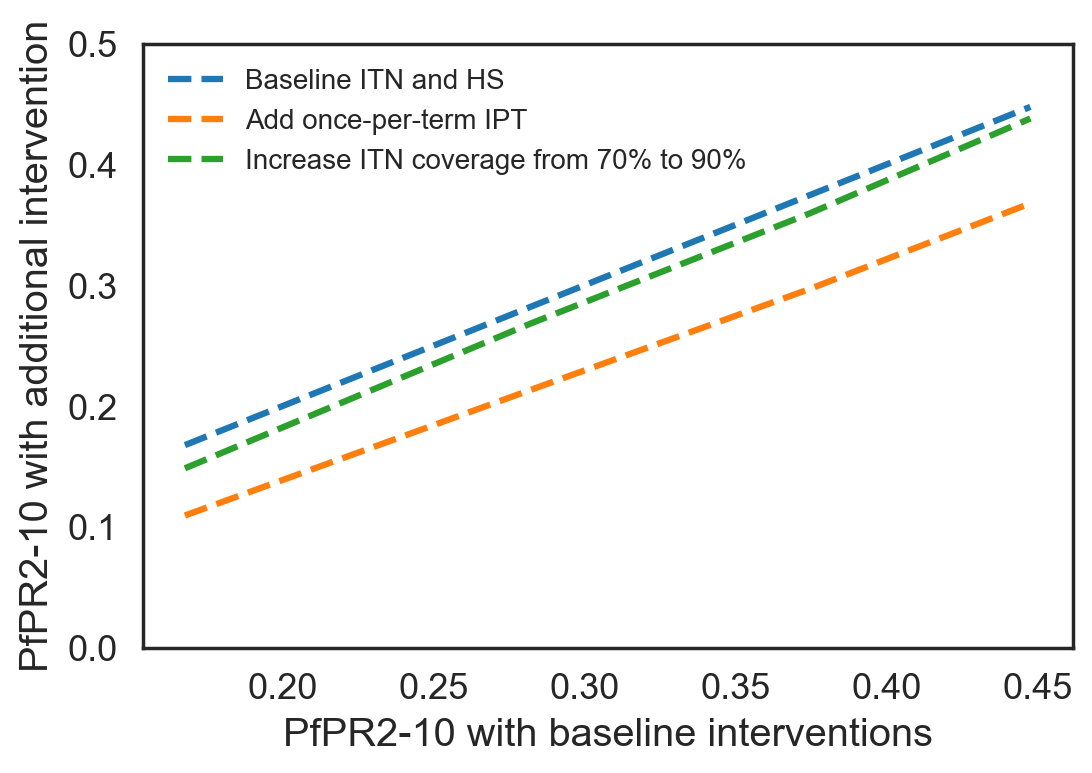

In [7]:
# Default IPT vs higher ITN coverage:
plt.figure(dpi=200)
plt.plot(np.array(df_baseline["pfpr2_10"]), np.array(df_baseline["pfpr2_10"]), linestyle='dashed', label="Baseline ITN and HS")
# plt.plot(np.array(df_baseline["pfpr2_10"]), np.array(df_allout["pfpr2_10"]), linestyle='dashed')

# Scenario 13: Southern,DP,IPT,term,default,default,0.9,0.15,default,False,13
s1 = df_agg_w_baseline[df_agg_w_baseline["scenario_number"]==13]
# Scenario 31: Southern,None,None,None,high,default,0.9,0.15,default,False,31
s2 = df_agg_w_baseline[df_agg_w_baseline["scenario_number"]==31]

plt.plot(s1["pfpr2_10_BASELINE"], s1["pfpr2_10"], linestyle='dashed', label="Add once-per-term IPT")
plt.plot(s2["pfpr2_10_BASELINE"], s2["pfpr2_10"], linestyle='dashed', label="Increase ITN coverage from 70% to 90%")

plt.legend(fontsize=10)
plt.ylim([0,0.5])

plt.xlabel("PfPR2-10 with baseline interventions")
plt.ylabel("PfPR2-10 with additional intervention")
# plt.plot( baseline

In [18]:
def modality_plot_by_group(scenarios, label_dict, suptitle=None, color_dict=None, linestyle_dict=None):
    plt.close("all")
    plt.figure(dpi=300, figsize=(10,5))
    
    metrics = ["pfpr0_5", "pfpr6_15", "pfpr15_500"]
    
    s_dict = {}
    for s in scenarios:
        s_dict[s] = df_agg_w_baseline[df_agg_w_baseline["scenario_number"]==s]
    
    for i in range(3):
        metric = metrics[i]
        ax = plt.subplot(1,3,i+1)
        
        if metric == "pfpr0_5":
            plt.ylim([0,0.55]) #0.28
        elif metric == "pfpr6_15":
            plt.ylim([0,0.55])
        elif metric == "pfpr15_500":
            plt.ylim([0,0.55]) #0.25
        
        for s in scenarios:
            linestyle='solid'
            c = None
            if s == 30:
                linestyle='dashed'
                c = 'gray'
            else:
                if color_dict:
                    c = color_dict[s]
                if linestyle_dict:
                    linestyle = linestyle_dict[s]
                
            x = s_dict[s]["{}_BASELINE".format(metric)]
            y = s_dict[s][metric]
            plt.plot(x,y, label=label_dict[s], linestyle=linestyle, c=c)

        if i == 2:
            plt.legend(fontsize=10)
        plt.xlabel("Baseline prevalence".format(metric))
        plt.ylabel(metric)
#         plt.title(metric)

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

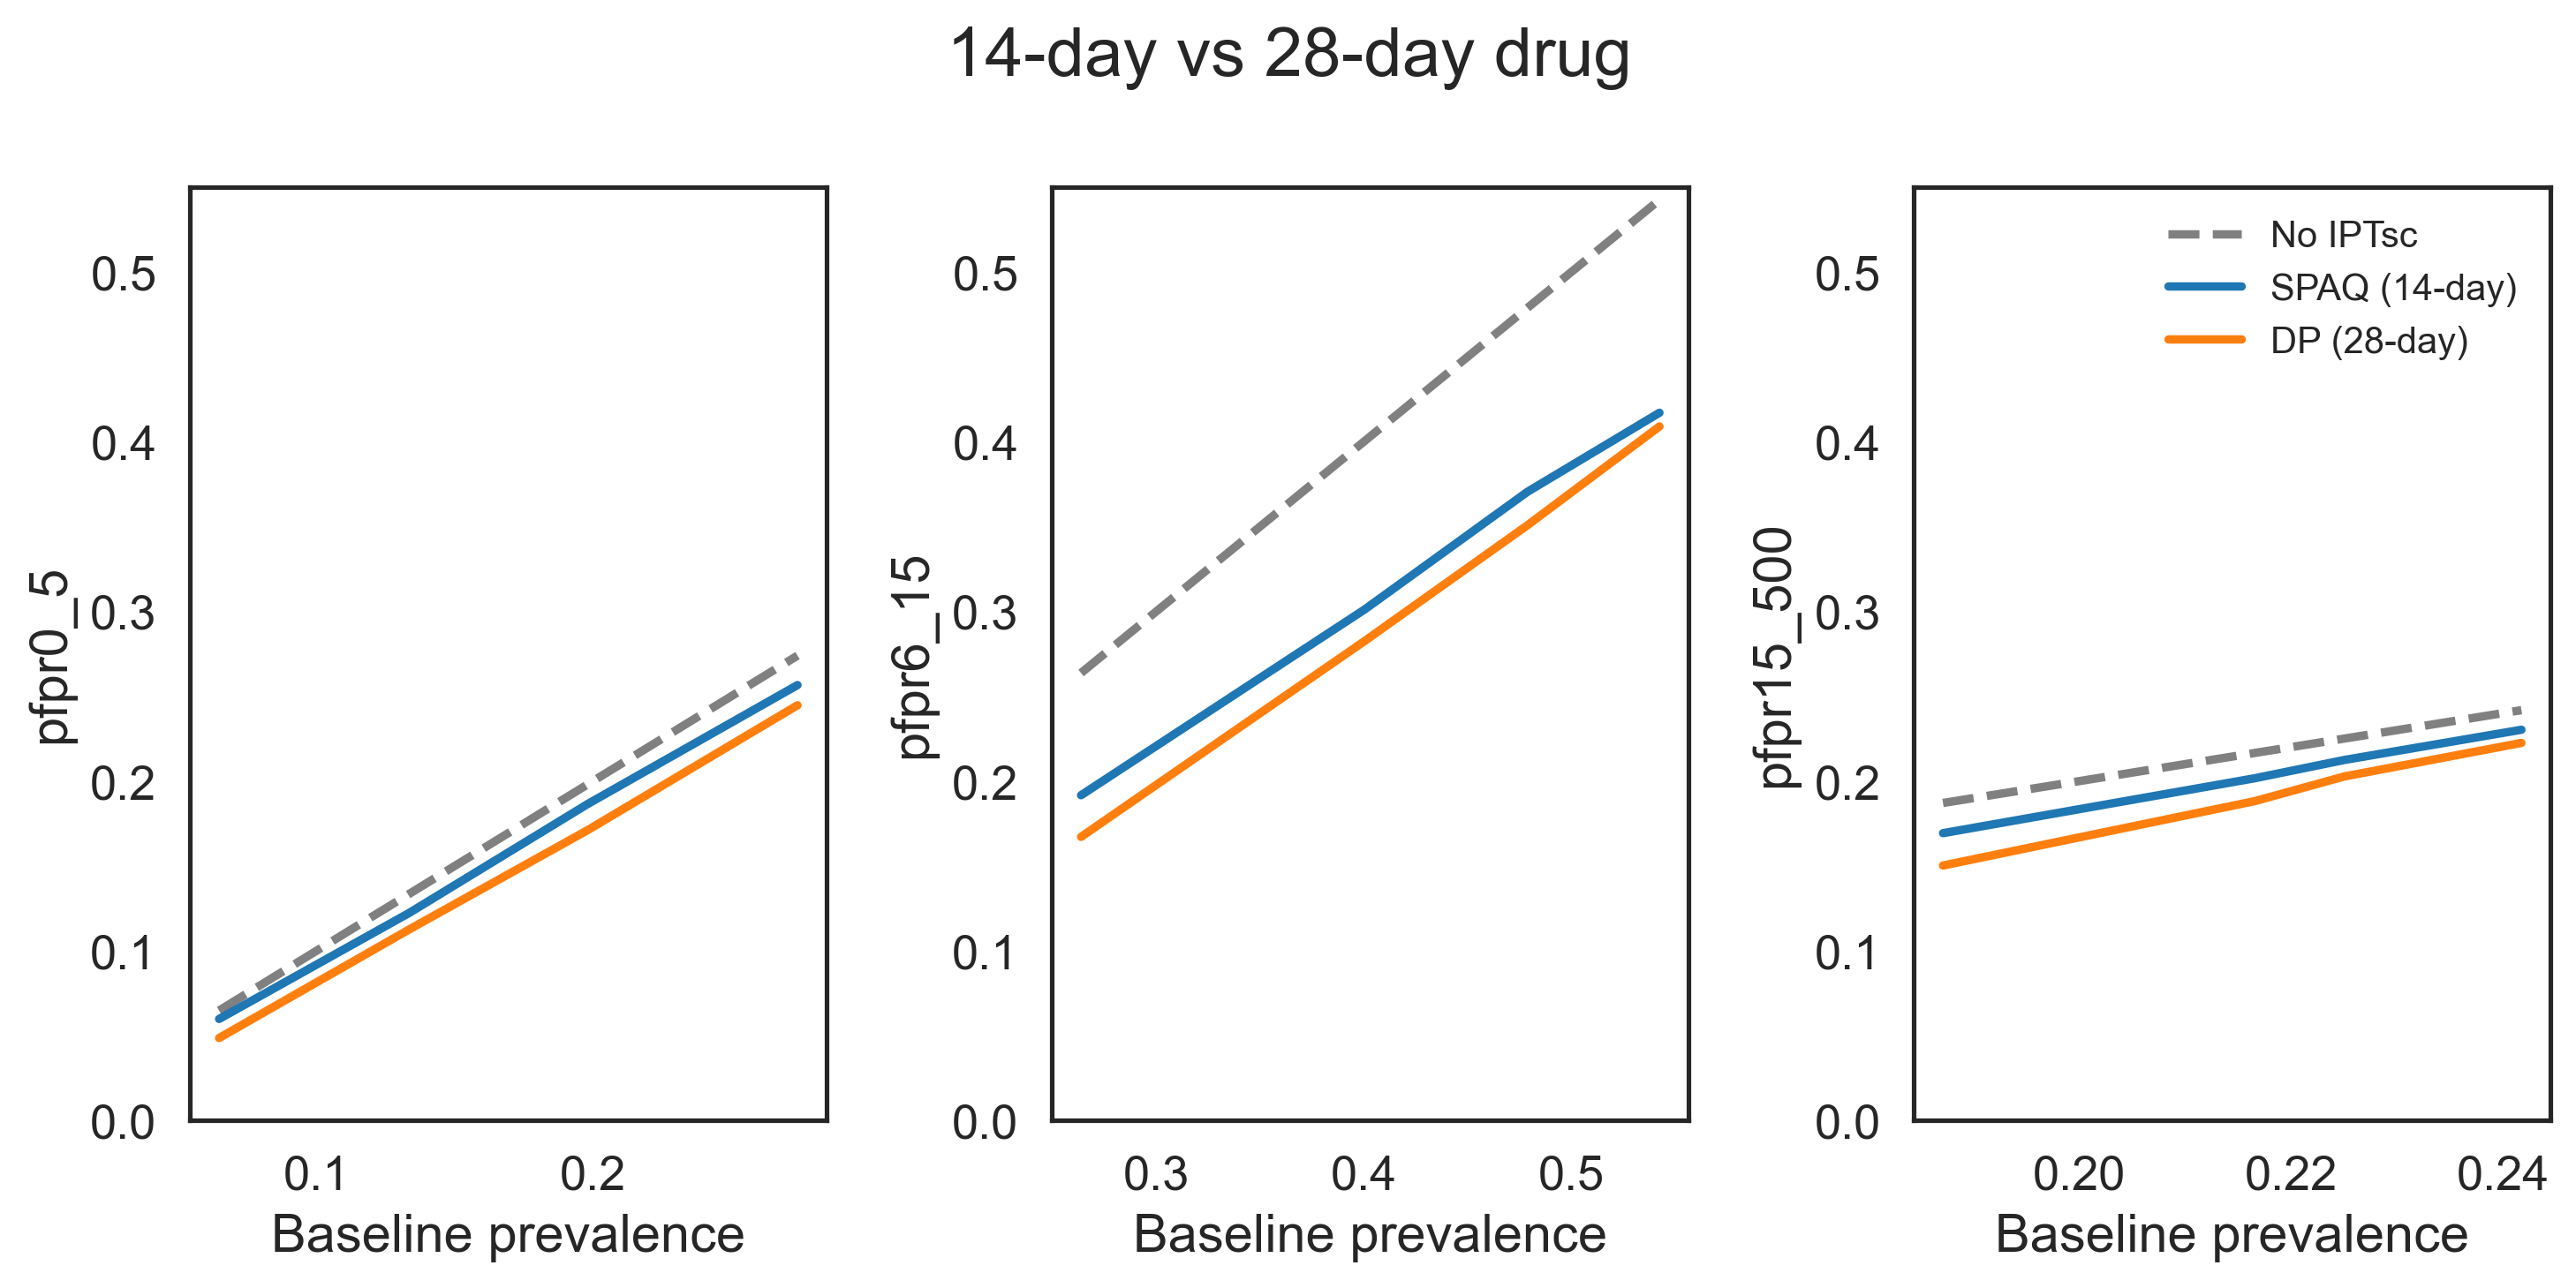

In [20]:
scenario_dict = {
    30: "No IPTsc",
    13: "DP (28-day)",
    1: "SPAQ (14-day)"
}
modality_plot_by_group([30,1,13], scenario_dict, suptitle="14-day vs 28-day drug")

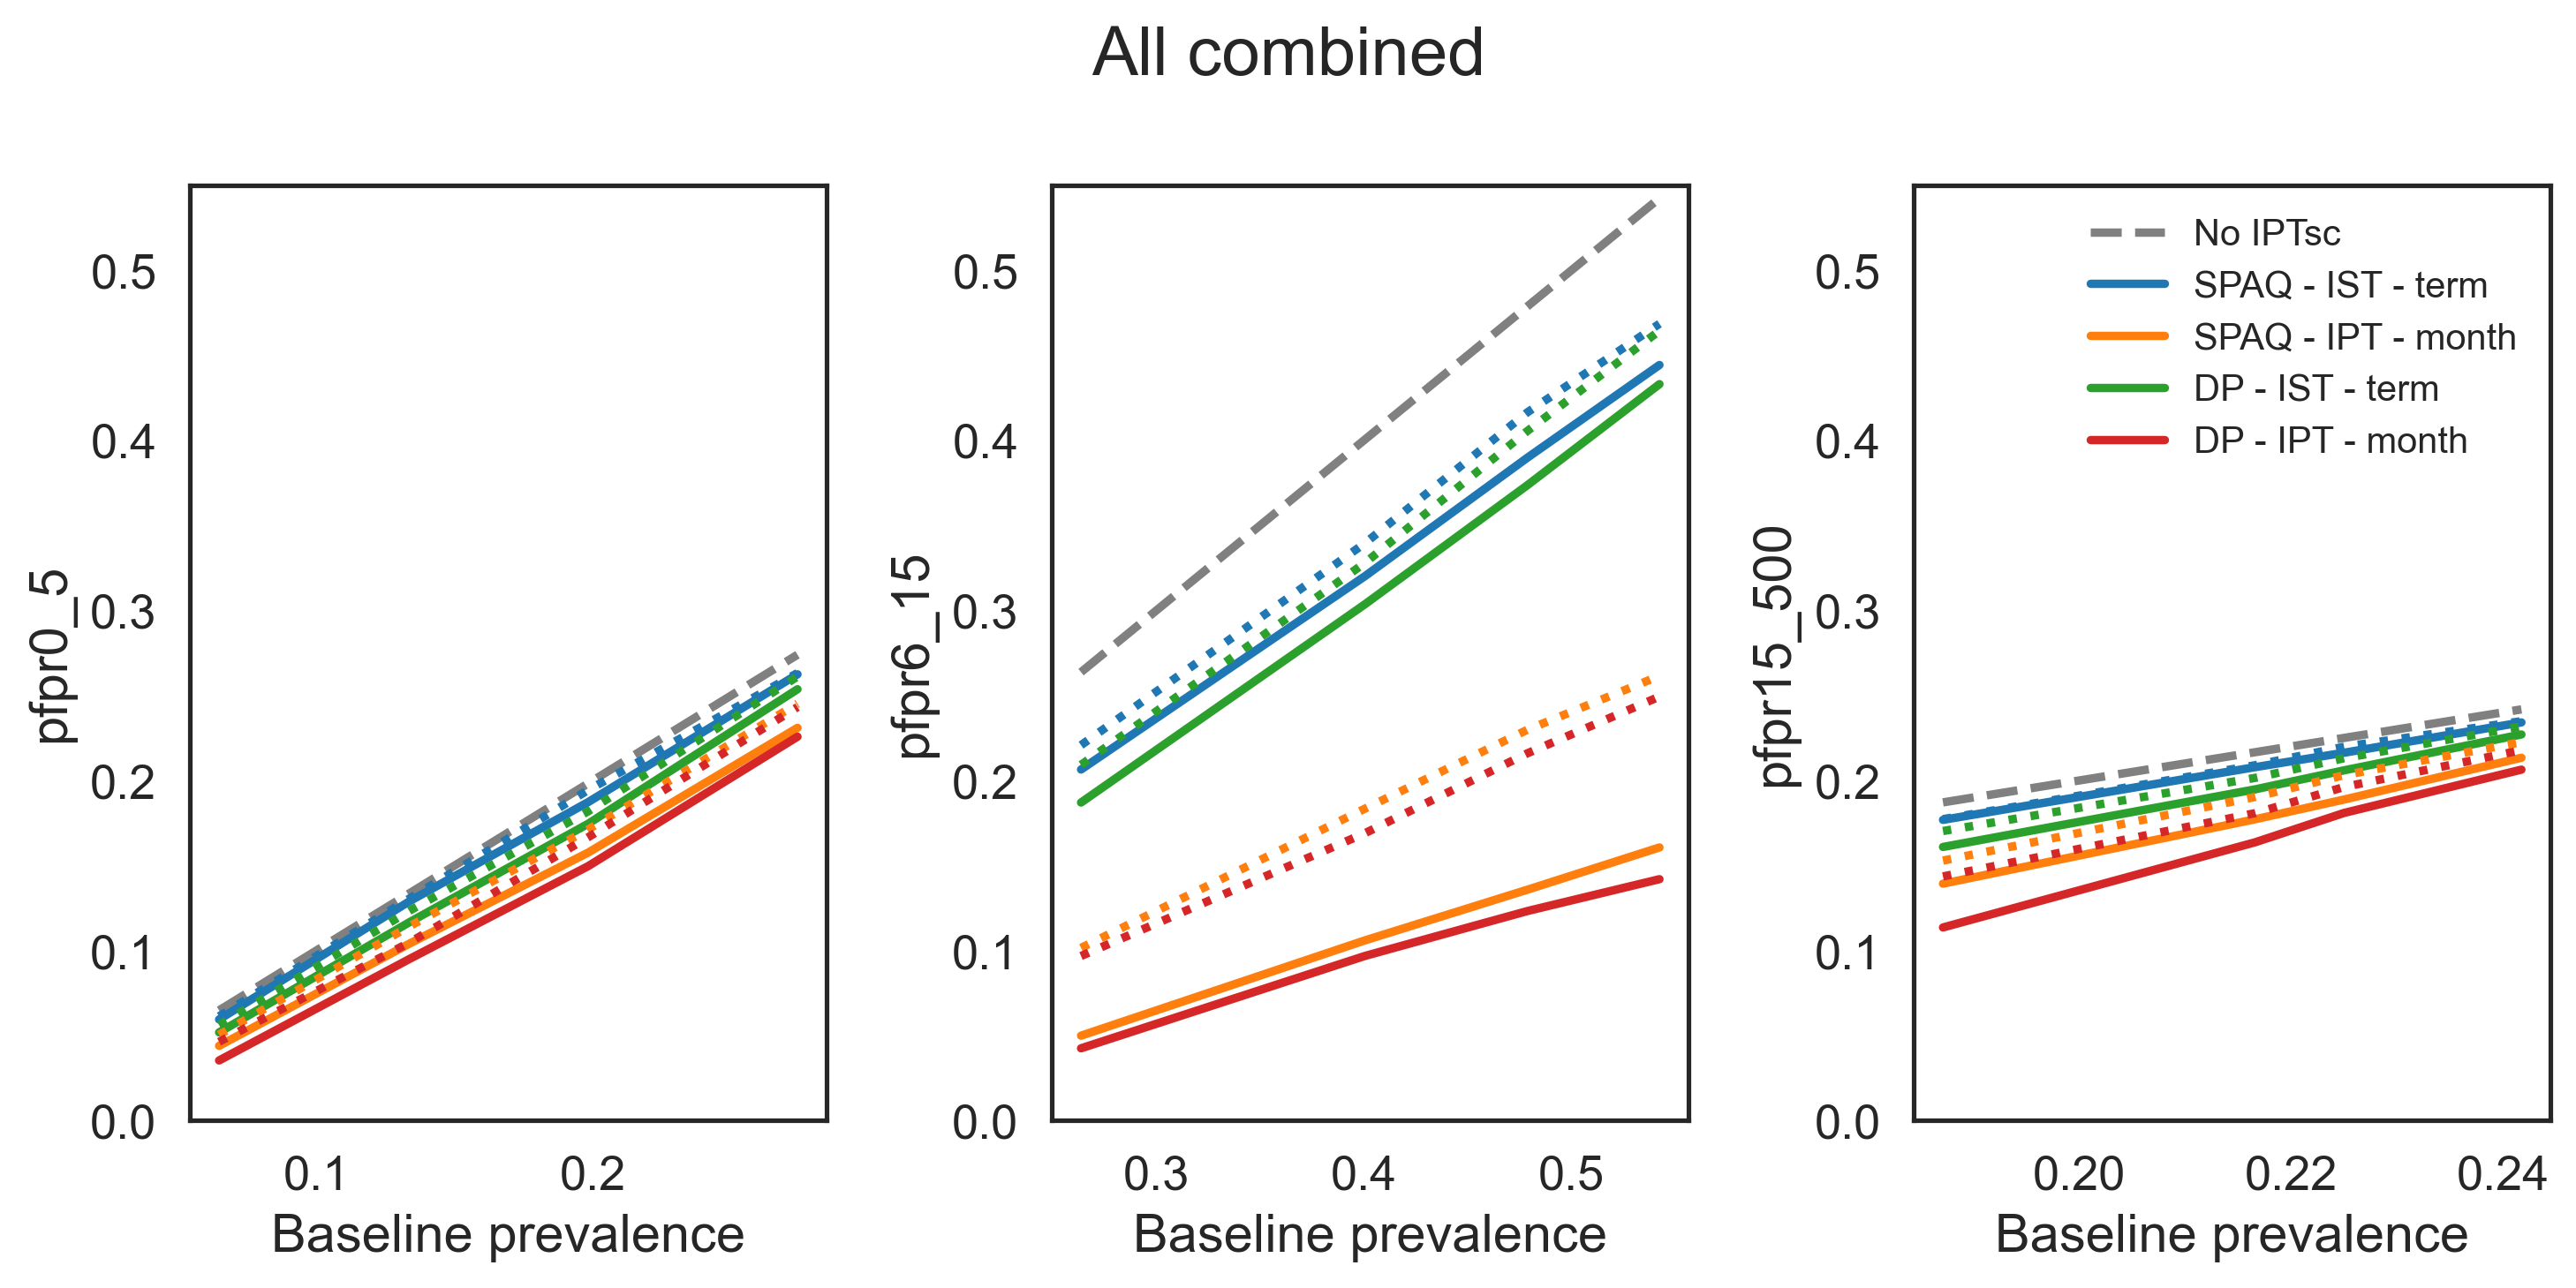

In [21]:
scenario_dict = {
    30: "No IPTsc",
    6: "SPAQ - IST - term",
    3: "SPAQ - IPT - month",
    18: "DP - IST - term",
    15: "DP - IPT - month",
    
    8: None,
    5: None,
    20: None,
    17: None,
}

s = [6,3,18,15]

color_dict = {}
linestyle_dict = {}
for i in range(len(s)):
    color_dict[s[i]] = "C{}".format(i)
    color_dict[s[i]+2] = "C{}".format(i)
    linestyle_dict[s[i]] = "solid"
    linestyle_dict[s[i]+2] = "dotted"
    
modality_plot_by_group(list(scenario_dict.keys()), 
                       scenario_dict, 
                       suptitle="All combined", 
                       color_dict=color_dict, 
                       linestyle_dict=linestyle_dict)

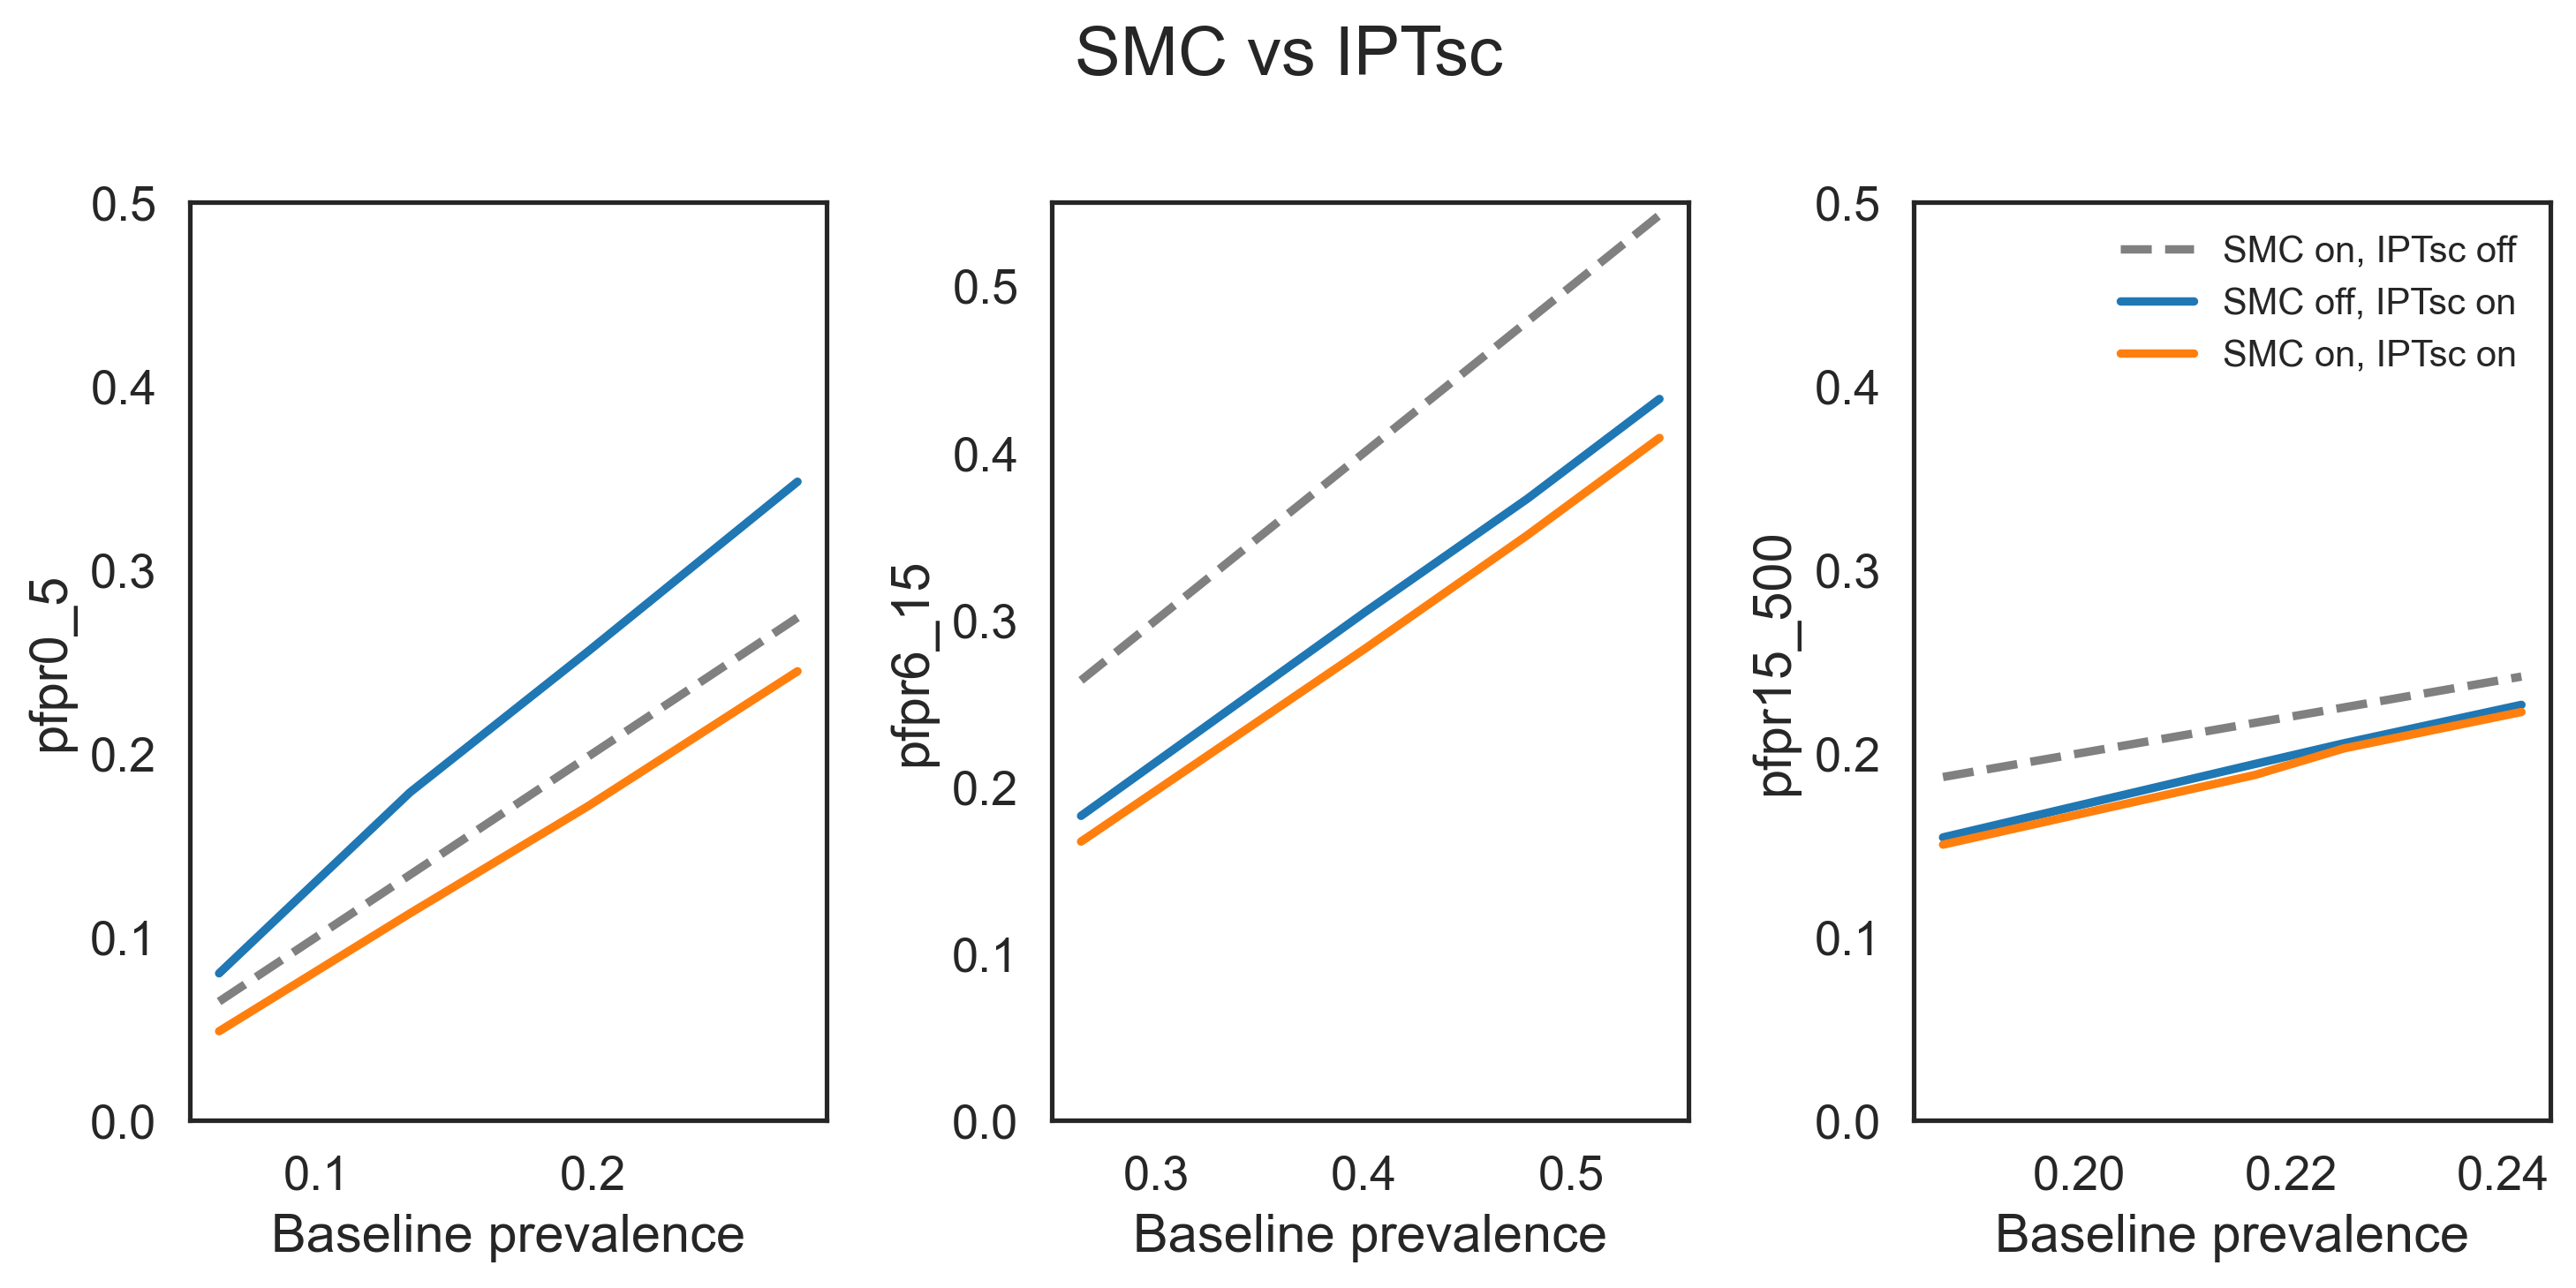

In [17]:
scenario_dict = {
    30: "SMC on, IPTsc off",
    34: "SMC off, IPTsc on",
    13: "SMC on, IPTsc on",
}

modality_plot_by_group(list(scenario_dict.keys()), 
                       scenario_dict, 
                       suptitle="SMC vs IPTsc")

## Trying out heatmaps

In [103]:
foo = df_agg_w_baseline.copy()
#     f2 = foo[foo["drug_pack"]=="Pure IVM MDA"].pivot("VC Coverage", "MDA Coverage", "elim_eoy2_frac")
#     sns.heatmap(f2, annot=True)

<AxesSubplot:xlabel='burnin_approx_pfpr2_10', ylabel='scenario_number'>

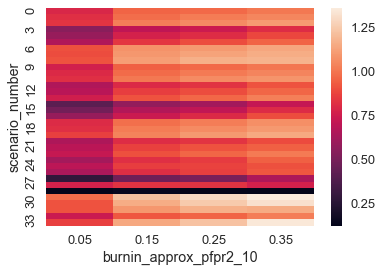

In [95]:
bar = foo.pivot("scenario_number", "burnin_approx_pfpr2_10", "clinical_incidence_all")
sns.heatmap(bar)

In [52]:
foo.columns

Index(['burnin_approx_pfpr2_10', 'scenario_number', 'pfpr0_5', 'pfpr2_10',
       'pfpr6_15', 'pfpr15_500', 'pfpr_all', 'clinical_incidence0_5',
       'clinical_incidence2_10', 'clinical_incidence6_15',
       'clinical_incidence15_500', 'clinical_incidence_all',
       'severe_incidence0_5', 'severe_incidence2_10', 'severe_incidence6_15',
       'severe_incidence15_500', 'severe_incidence_all', 'pop0_5', 'pop2_10',
       'pop6_15', 'pop15_500', 'pop_all', 'burnin_habitat_scale',
       'out_of_school_rate', 'Run_Number', 'smc_on', 'within_school_coverage',
       'Received_Treatment', 'Received_Test', 'Received_Campaign_Drugs',
       'Received_RCD_Drugs', 'Received_SMC', 'Received_Ivermectin',
       'Received_Primaquine', 'pfpr0_5_BASELINE', 'pfpr2_10_BASELINE',
       'pfpr6_15_BASELINE', 'pfpr15_500_BASELINE', 'pfpr_all_BASELINE',
       'clinical_incidence0_5_BASELINE', 'clinical_incidence2_10_BASELINE',
       'clinical_incidence6_15_BASELINE', 'clinical_incidence15_500_BASELI

<AxesSubplot:xlabel='burnin_approx_pfpr2_10', ylabel='scenario_number'>

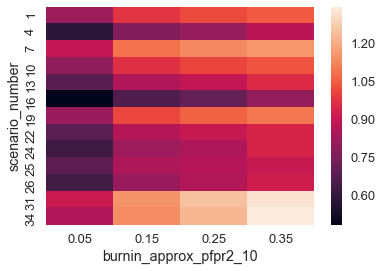

In [96]:
bar = foo[foo["out_of_school_rate"]==0.15].pivot("scenario_number", "burnin_approx_pfpr2_10", "clinical_incidence_all")
sns.heatmap(bar)

In [135]:
intervention_name_list = {}
intervention_name_list["Sahel"] = [
    "SPAQ_IST_term",
    "SPAQ_IST_month",
    "SPAQ_IPT_term",
    "SPAQ_IPT_month",
    "DP_IST_term",
    "DP_IST_month",
    "DP_IPT_term",
    "DP_IPT_month",
    "DP_IPT_day"
]

intervention_name_list["Southern"] = [
    "ASAQ_IST_term",
    "ASAQ_IST_month",
    "ASAQ_IPT_term",
    "ASAQ_IPT_month",
    "DP_IST_term",
    "DP_IST_month",
    "DP_IPT_term",
    "DP_IPT_month",
    "DP_IPT_day"
]
# bar['intervention_name'] = pd.Categorical(bar['intervention_name'], ["March", "April", "Dec"])

c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

Text(0.5, 1.0, 'Sahel')

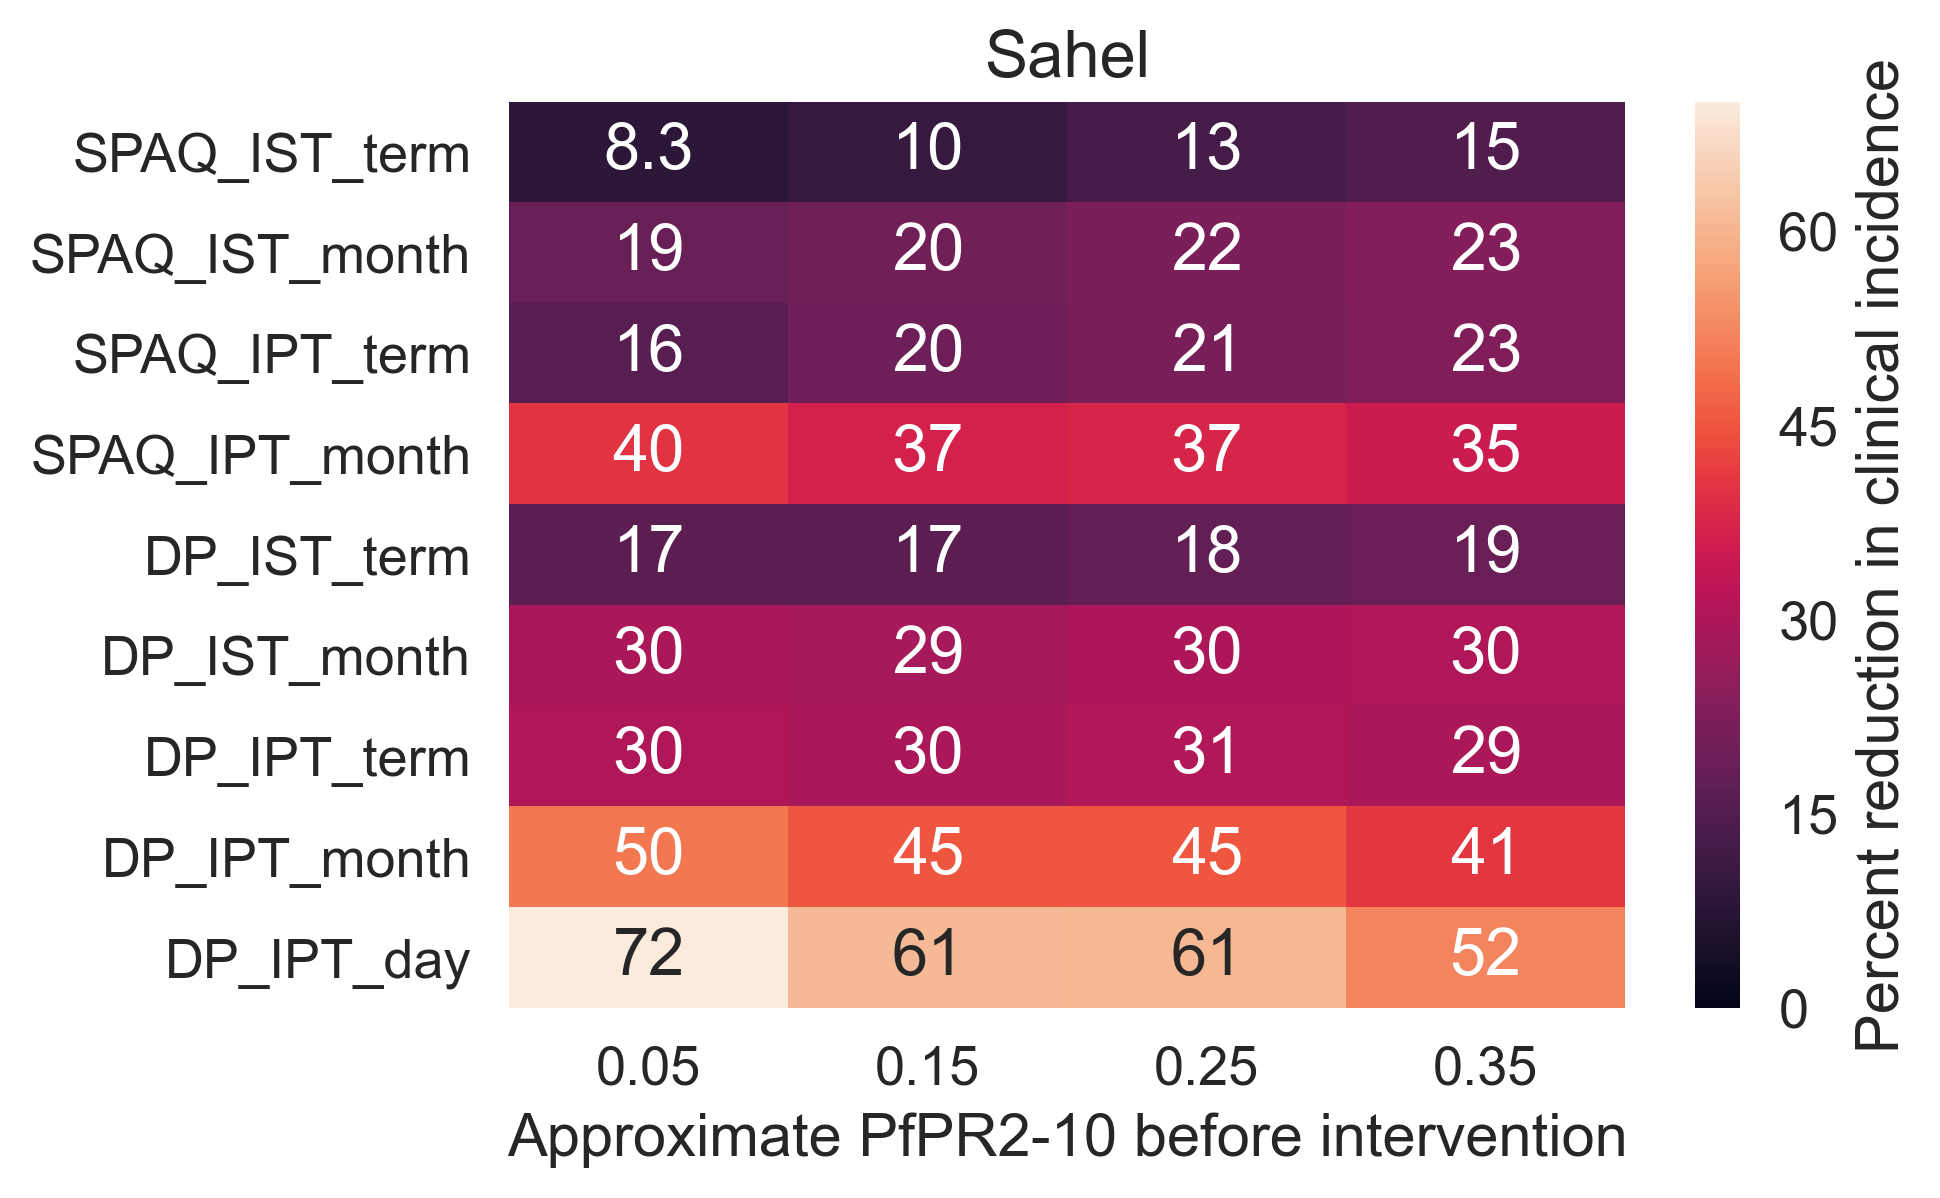

In [144]:
plt.figure(dpi=300)
archetype = "Sahel"
foo = get_agg_df_w_baseline(archetype)
# bar = foo[foo["out_of_school_rate"]==0.15]
bar = foo[np.in1d(foo["scenario_number"], [1,4,7,10,13,16,19,22,27])]
bar["Clinical Incidence Reduction"] = 100*(bar["clinical_incidence_all_BASELINE"]-bar["clinical_incidence_all"])/bar["clinical_incidence_all_BASELINE"]
bar["intervention_name"] = bar["drug_type"]+"_"+bar["screen_type"]+"_"+bar["interval"]
# bar.sort_values(by=['drug_type', "screen_type", "interval"], ascending=True)

bar['intervention_name'] = pd.Categorical(bar['intervention_name'], intervention_name_list[archetype])
bar.sort_values(by="intervention_name")

bar = bar.pivot("intervention_name", "burnin_approx_pfpr2_10", "Clinical Incidence Reduction")
sns.heatmap(bar, annot=True,cbar_kws={'label': 'Percent reduction in clinical incidence'}, vmin=0, vmax=70)
plt.ylabel(None)
plt.xlabel("Approximate PfPR2-10 before intervention")
plt.title(archetype)

c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

Text(0.5, 1.0, 'Southern')

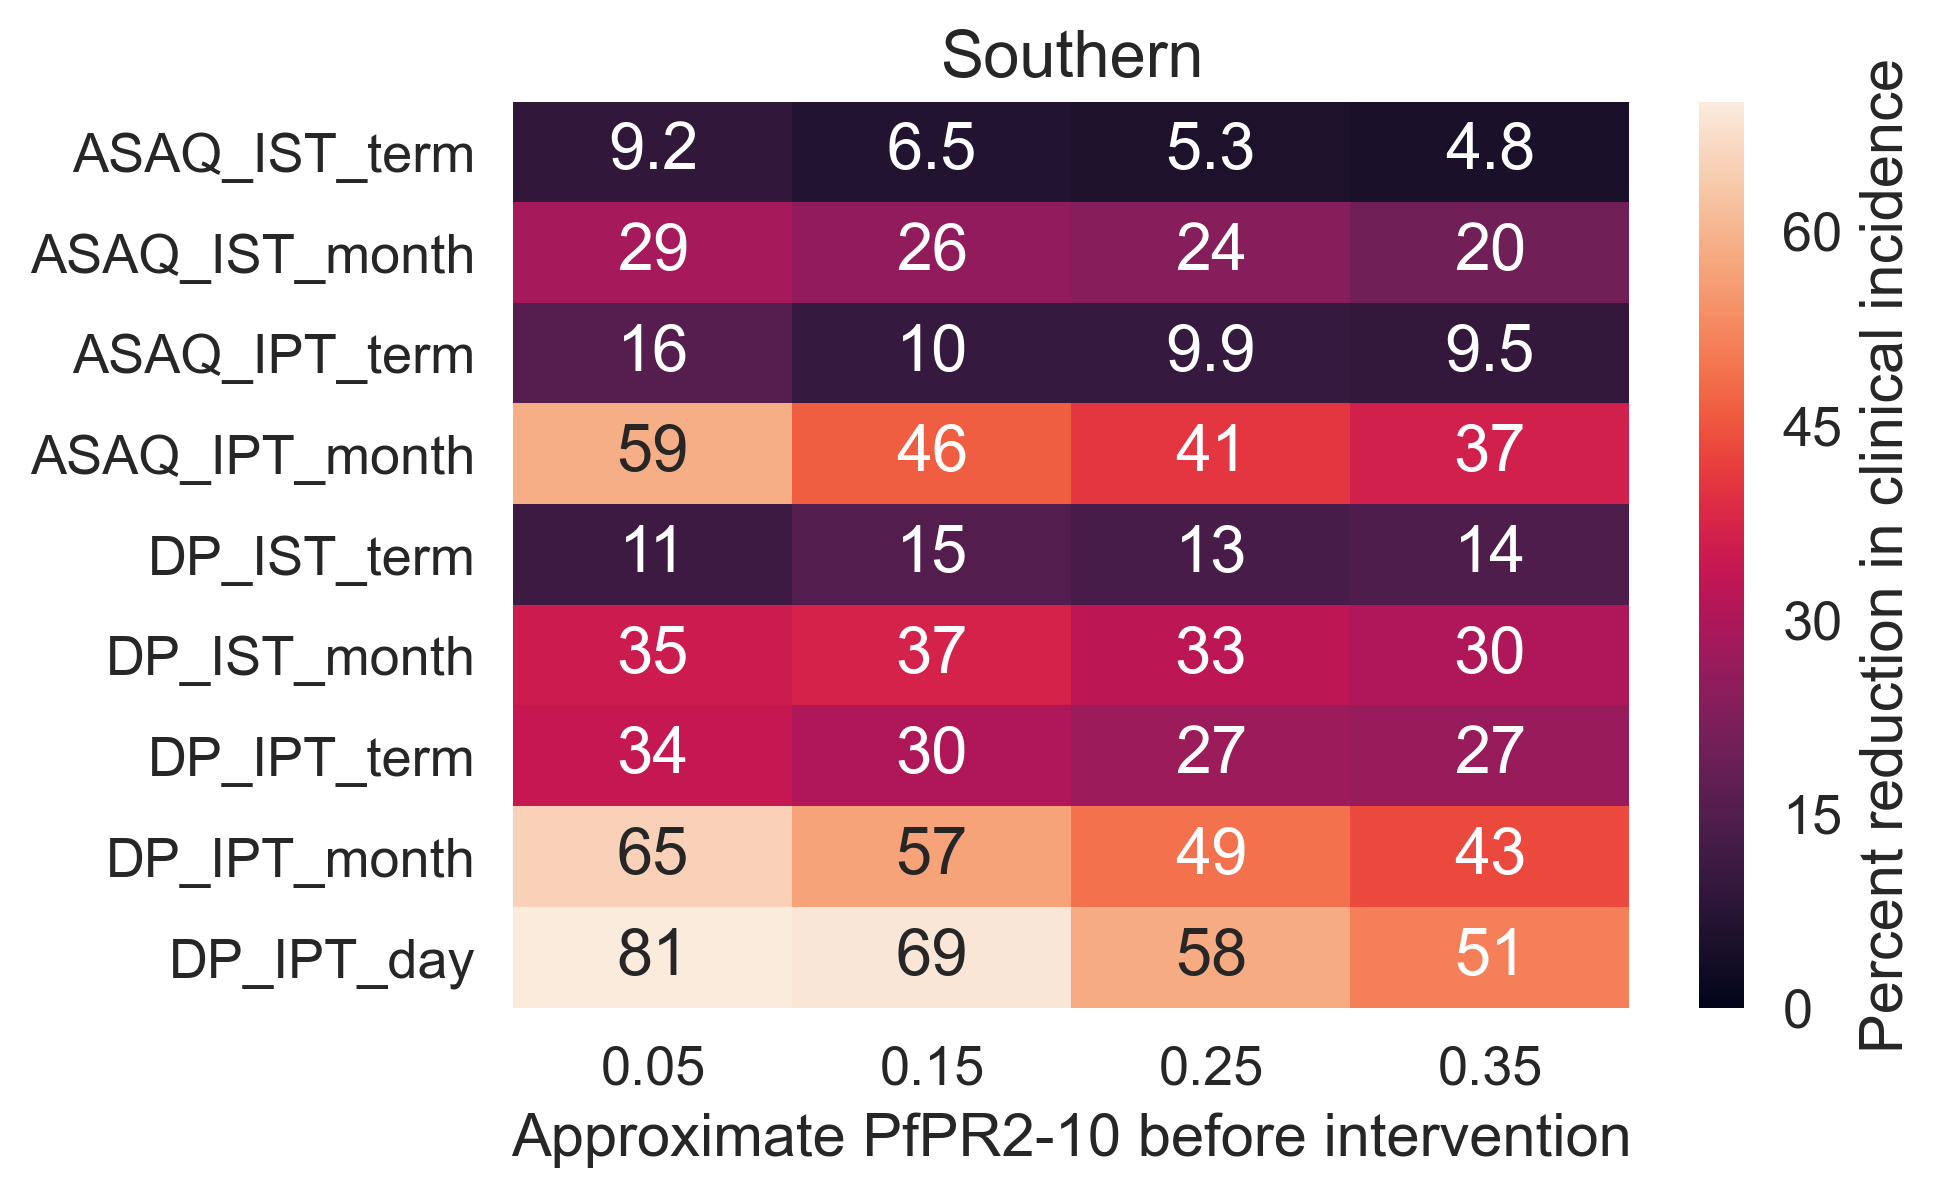

In [143]:
plt.figure(dpi=300)
archetype="Southern"
foo = get_agg_df_w_baseline(archetype)
# bar = foo[foo["out_of_school_rate"]==0.15]
bar = foo[np.in1d(foo["scenario_number"], [1,4,7,10,13,16,19,22,27])]
bar["Clinical Incidence Reduction"] = 100*(bar["clinical_incidence_all_BASELINE"]-bar["clinical_incidence_all"])/bar["clinical_incidence_all_BASELINE"]
bar["intervention_name"] = bar["drug_type"]+"_"+bar["screen_type"]+"_"+bar["interval"]

bar['intervention_name'] = pd.Categorical(bar['intervention_name'], intervention_name_list[archetype])
bar.sort_values(by="intervention_name")

bar = bar.pivot("intervention_name", "burnin_approx_pfpr2_10", "Clinical Incidence Reduction")
sns.heatmap(bar, annot=True,cbar_kws={'label': 'Percent reduction in clinical incidence'}, vmin=0, vmax=70)
plt.ylabel(None)
plt.xlabel("Approximate PfPR2-10 before intervention")
plt.title(archetype)

Text(0.5, 1.0, 'Sahel')

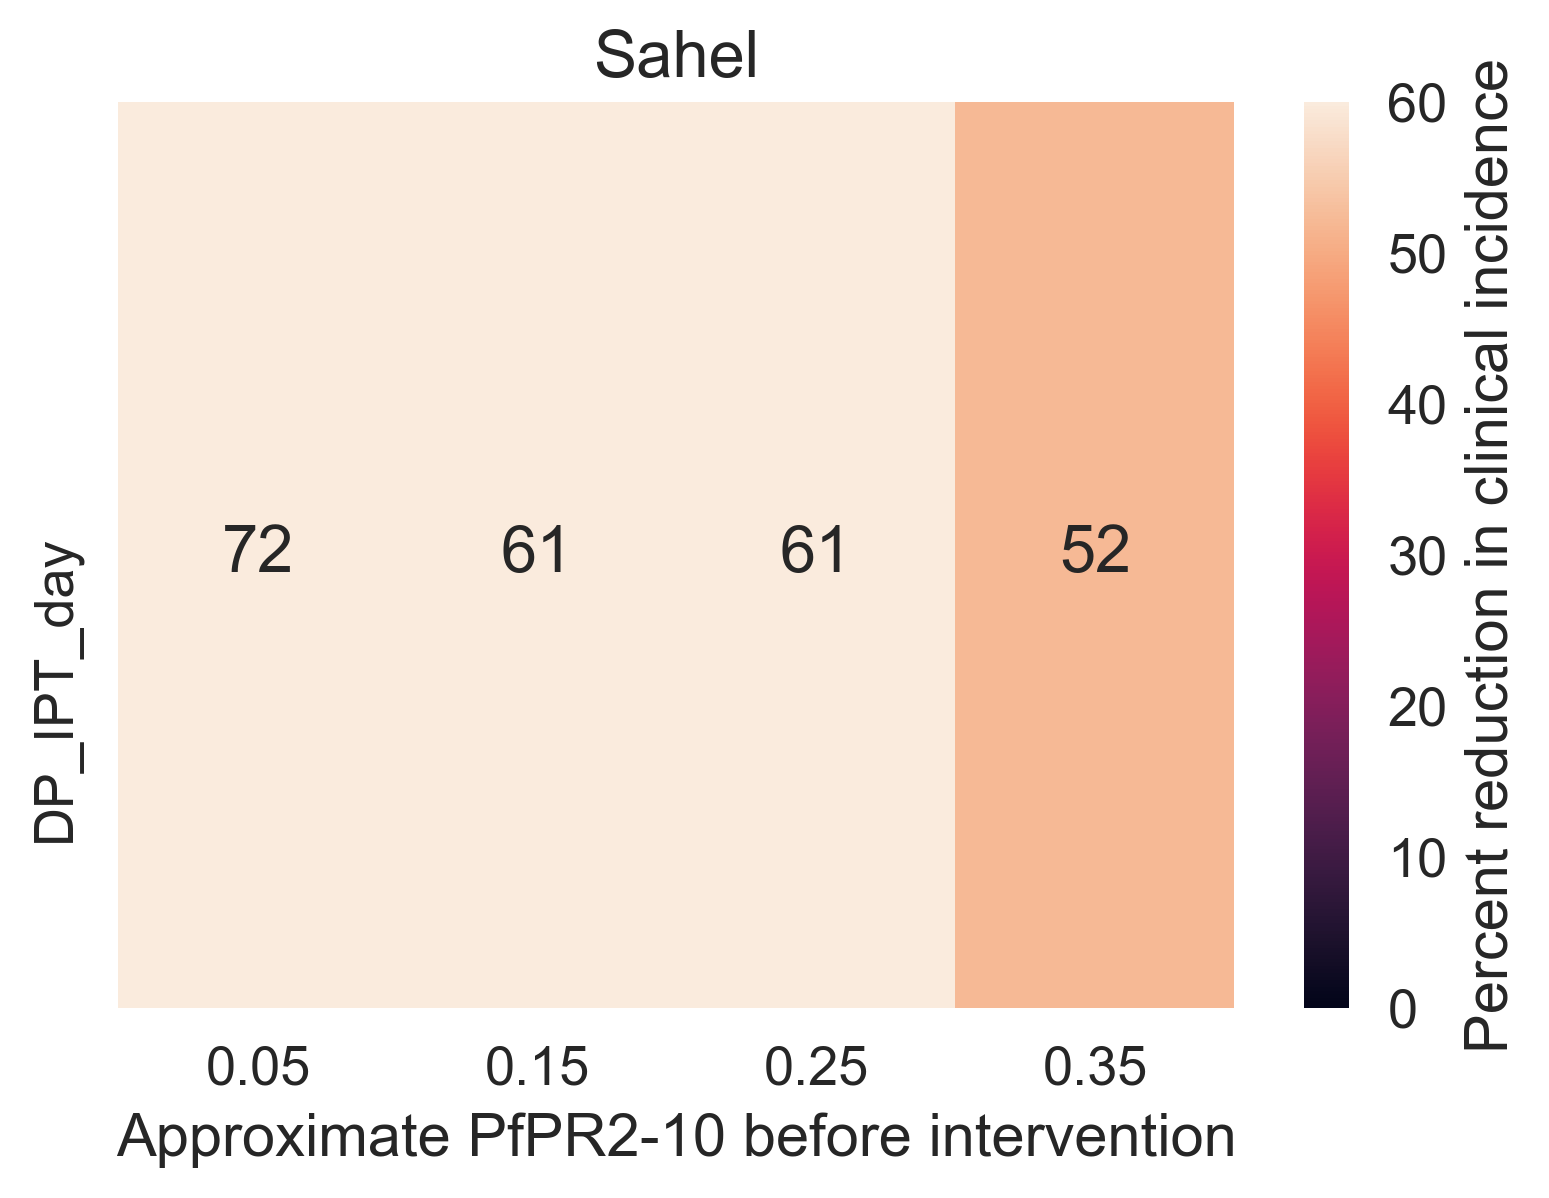

In [139]:
plt.figure(dpi=300)
archetype = "Sahel"
foo = get_agg_df_w_baseline(archetype)
bar = foo[foo["out_of_school_rate"]==0]
bar = bar[np.in1d(bar["scenario_number"], [27])]
bar["Clinical Incidence Reduction"] = 100*(bar["clinical_incidence_all_BASELINE"]-bar["clinical_incidence_all"])/bar["clinical_incidence_all_BASELINE"]
bar["intervention_name"] = bar["drug_type"]+"_"+bar["screen_type"]+"_"+bar["interval"]
# bar.sort_values(by=['drug_type', "screen_type", "interval"], ascending=True)

bar['intervention_name'] = pd.Categorical(bar['intervention_name'], intervention_name_list[archetype])
bar.sort_values(by="intervention_name")

bar = bar.pivot("intervention_name", "burnin_approx_pfpr2_10", "Clinical Incidence Reduction")
sns.heatmap(bar, annot=True,cbar_kws={'label': 'Percent reduction in clinical incidence'}, vmin=0, vmax=60)
plt.ylabel(None)
plt.xlabel("Approximate PfPR2-10 before intervention")
plt.title(archetype)

Text(0.5, 1.0, 'Southern')

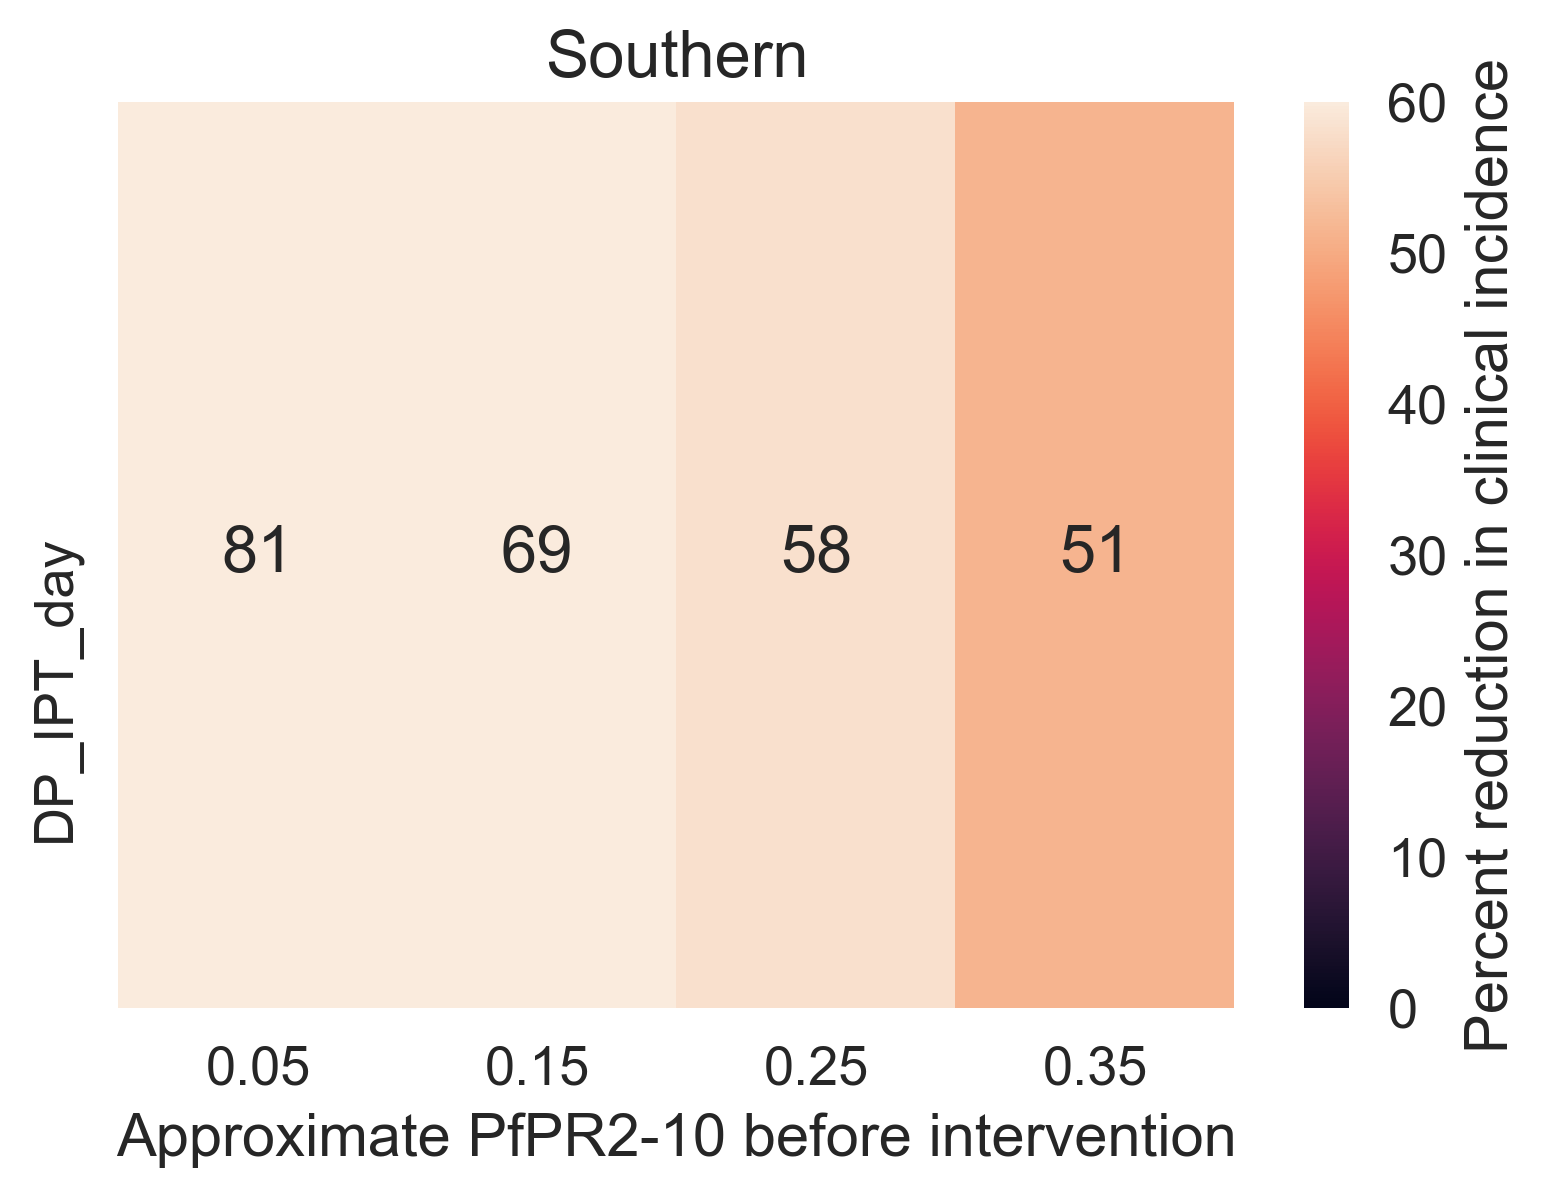

In [140]:
plt.figure(dpi=300)
archetype = "Southern"
foo = get_agg_df_w_baseline(archetype)
bar = foo[foo["out_of_school_rate"]==0]
bar = bar[np.in1d(bar["scenario_number"], [27])]
bar["Clinical Incidence Reduction"] = 100*(bar["clinical_incidence_all_BASELINE"]-bar["clinical_incidence_all"])/bar["clinical_incidence_all_BASELINE"]
bar["intervention_name"] = bar["drug_type"]+"_"+bar["screen_type"]+"_"+bar["interval"]
# bar.sort_values(by=['drug_type', "screen_type", "interval"], ascending=True)

bar['intervention_name'] = pd.Categorical(bar['intervention_name'], intervention_name_list[archetype])
bar.sort_values(by="intervention_name")

bar = bar.pivot("intervention_name", "burnin_approx_pfpr2_10", "Clinical Incidence Reduction")
sns.heatmap(bar, annot=True,cbar_kws={'label': 'Percent reduction in clinical incidence'}, vmin=0, vmax=60)
plt.ylabel(None)
plt.xlabel("Approximate PfPR2-10 before intervention")
plt.title(archetype)